In [17]:
import numpy as np
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
import random

In [3]:
batch_size = 32
dataset_dir = 'dataset/FreiHAND/FreiHAND_pub_v2'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

# Make DataLoaders

Dataset: FreiHAND

In [87]:
from utils import load_db_annotation, read_img, colors, bones, projectPoints, db_size


class KeypointsDataset(Dataset):

    def __init__(self, path_to_dataset, split_type, dataset_type='gs', ):
        self.preprocessing = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2()
        ])
        self.annotations = list(load_db_annotation(path_to_dataset, split_type))
        self.split_type = split_type
        self.dataset_type = dataset_type
        self.path_to_dataset = path_to_dataset

    def __len__(self):
        return db_size(self.split_type)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        K, mano, xyz = self.annotations[idx]
        uv = projectPoints(xyz, K)
        # uv -= 112
        uv /= 224
        image_path = read_img(idx, self.path_to_dataset, self.split_type, self.dataset_type)
        image = Image.open(image_path).convert('RGB')
        image = np.asarray(image)
        image = self.preprocessing(image=image)['image']
            
        keypoints = []
        for x,y in uv:
            keypoints.extend([x,y])

        return image, torch.Tensor(keypoints)

In [88]:
train_dataset = KeypointsDataset("dataset/FreiHAND/FreiHAND_pub_v2/","training","auto")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

val_dataset = KeypointsDataset("dataset/FreiHAND/FreiHAND_pub_v2_eval","evaluation")
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Loading FreiHAND dataset index ...
Loading of 32560 samples done in 1.88 seconds
Loading FreiHAND dataset index ...
Loading of 3960 samples done in 0.15 seconds


# Test DataLoader

In [89]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# denorm = A.Normalize(mean=mean, std=std, always_apply=True)

def denorm(img_tensors):
    return mean[0] * img_tensors + std[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


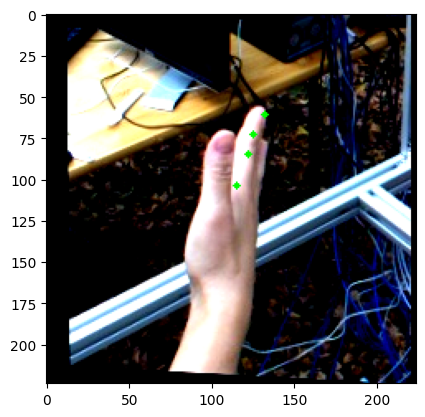

In [293]:
for imgs, lbls in val_dataloader:
    randint_ = random.randint(0, batch_size)
    # randint_ = 0 
    img = denorm(imgs[randint_])
    img = np.transpose(img, (1,2,0))
    img = np.array(img).copy()
    lbl = np.array(lbls[randint_])
    # for i in range(0, len(lbl), 2):
    for i in range(10, 17, 2):
        x = int(lbl[i]*224 )
        y = int(lbl[i+1] * 224)
        img = cv2.circle(img, (x, y), 2, (0, 255, 0), -1)
    plt.imshow(img)
    break
        

# Metrics

## Object Keypoint Similarity

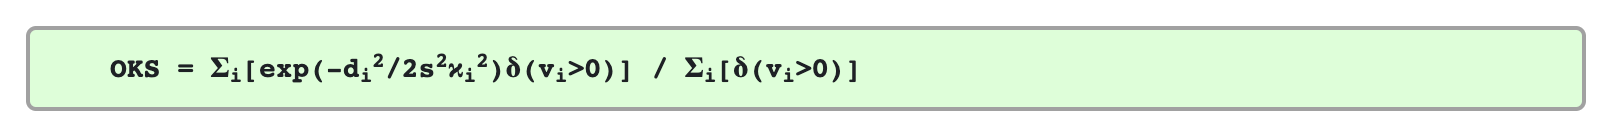

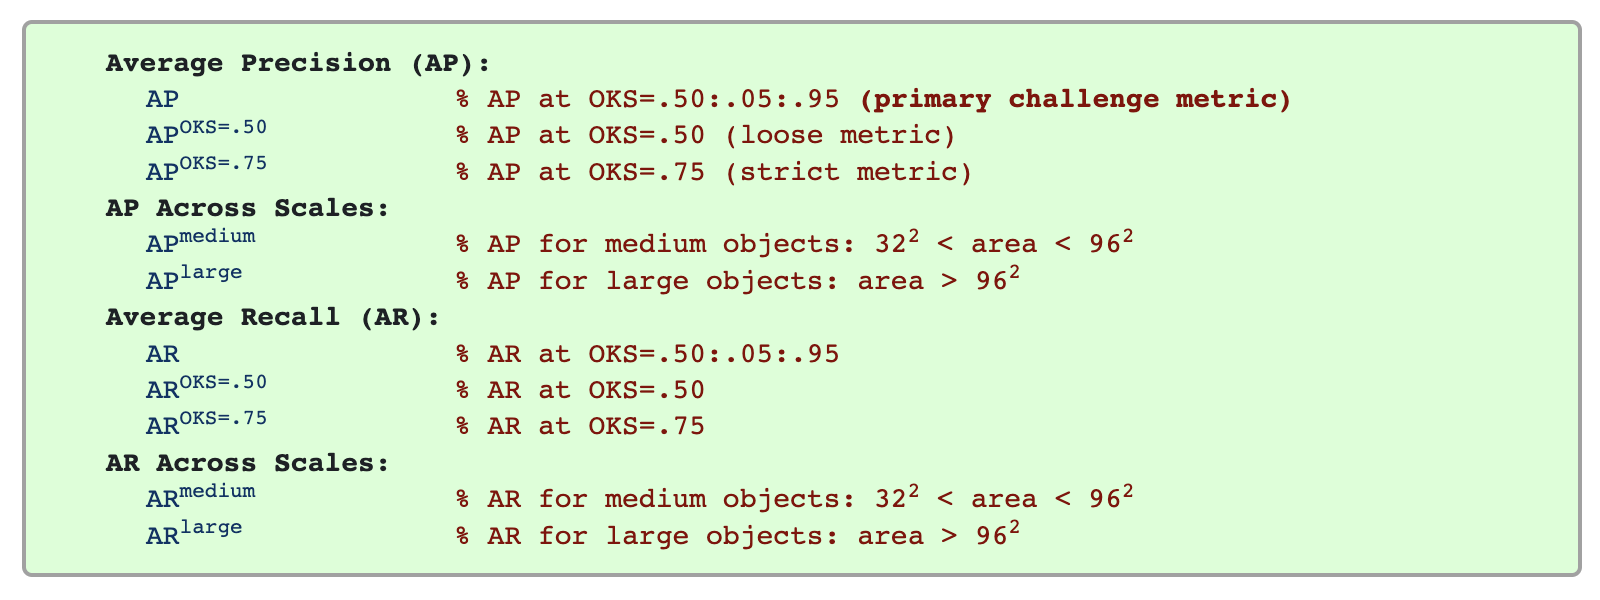

In [91]:
def oks(y_true, y_pred, visibility):
    # You might want to set these global constant
    # outside the function scope
    KAPPA = np.array([1] * len(y_true))
    # The object scale
    # You might need a dynamic value for the object scale
    SCALE = 1.0

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    # Compute the exponential part of the equation
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    # The numerator expression
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    # The denominator expression
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

# Create model

In [92]:
model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
model.global_pool = nn.Flatten()
model.classifier = nn.Sequential(
    nn.Linear(62720, 42),
    nn.Sigmoid()
)
model.to(device);

# Train

In [93]:
EPOCHS = 100
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr)

criterion = nn.MSELoss()

In [94]:
for epoch in range(EPOCHS):
    
    model.train()
        
    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        targets = targets.to(device)
        
        predictions = model(batch)
        loss = criterion(predictions, targets) 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
        predictions = predictions.cpu().detach().numpy().reshape(-1, 2)
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy().reshape(-1, 2)
        train_targets.extend(targets)
    
    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)
    print('Training loss:', np.mean(train_loss))
    print('Train OKS:', oks(train_targets[:, :1], train_predictions[:, :1], train_targets[:, 1]))
    
    model.eval()
        
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            predictions = predictions.cpu().numpy().reshape(-1, 2)
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy().reshape(-1, 2)
            val_targets.extend(targets)
        
    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)
    print('Val OKS:', oks(val_targets[:, :1], val_predictions[:, :1], val_targets[:, 1]))

Epoch: 0:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0037988568951187324
Train OKS: 0.9980485515275472


Epoch: 0:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9976654731547935


Epoch: 1:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0022722673472035347
Train OKS: 0.9988428193418407


Epoch: 1:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9975438645464291


Epoch: 2:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0017751645138313398
Train OKS: 0.999095470381967


Epoch: 2:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9975189309855427


Epoch: 3:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0014729656428094104
Train OKS: 0.9992484481745245


Epoch: 3:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9974877639071144


Epoch: 4:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0012654621714533055
Train OKS: 0.9993549019281237


Epoch: 4:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9974410573731955


Epoch: 5:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0011153118074222052
Train OKS: 0.9994300135825706


Epoch: 5:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9974205585055291


Epoch: 6:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0010036272200923194
Train OKS: 0.9994902540979224


Epoch: 6:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973626050520191


Epoch: 7:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0009130565264337278
Train OKS: 0.9995349324710328


Epoch: 7:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9972915054966354


Epoch: 8:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0008447785835030666
Train OKS: 0.9995695858736575


Epoch: 8:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973645572557398


Epoch: 9:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0007755630016660827
Train OKS: 0.9996047492447782


Epoch: 9:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9972965983696357


Epoch: 10:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0007312088926729411
Train OKS: 0.9996272528049004


Epoch: 10:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.997212078791035


Epoch: 11:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0006916045768688248
Train OKS: 0.9996467693968814


Epoch: 11:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.997296589507206


Epoch: 12:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0006478594755913974
Train OKS: 0.9996686483826477


Epoch: 12:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973044659628553


Epoch: 13:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0006171474675544993
Train OKS: 0.9996858492004806


Epoch: 13:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.997282144413422


Epoch: 14:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0005897130476505714
Train OKS: 0.9996991154312023


Epoch: 14:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.997326059022259


Epoch: 15:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0005657924673383258
Train OKS: 0.9997121574316064


Epoch: 15:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.997326244296222


Epoch: 16:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0005408264178561307
Train OKS: 0.9997239431912385


Epoch: 16:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973312754276624


Epoch: 17:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0005196976058415186
Train OKS: 0.999733768941607


Epoch: 17:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973589062761636


Epoch: 18:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0005060282741922132
Train OKS: 0.9997429085704448


Epoch: 18:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9972889846418577


Epoch: 19:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0004885228800638588
Train OKS: 0.9997504243761804


Epoch: 19:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973401380723722


Epoch: 20:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.00047394064699220954
Train OKS: 0.9997575822286471


Epoch: 20:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973451812632078


Epoch: 21:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0004613357467733759
Train OKS: 0.9997659230436389


Epoch: 21:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973788700102073


Epoch: 22:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.00044490420862767946
Train OKS: 0.9997724689758599


Epoch: 22:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.997369856965746


Epoch: 23:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0004337797441882537
Train OKS: 0.9997788188744104


Epoch: 23:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973921190059702


Epoch: 24:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0004221033101660348
Train OKS: 0.9997844635753317


Epoch: 24:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973920585419759


Epoch: 25:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.00041028691693812915
Train OKS: 0.999790623732995


Epoch: 25:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9973679091922381


Epoch: 26:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0004003478544864855
Train OKS: 0.9997959472134187


Epoch: 26:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9974067390413943


Epoch: 27:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0003955126464724164
Train OKS: 0.9997975618092166


Epoch: 27:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9974910544228334


Epoch: 28:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0003866911153899129
Train OKS: 0.9998031754979796


Epoch: 28:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9974698545756674


Epoch: 29:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0003711972109473005
Train OKS: 0.9998103022815023


Epoch: 29:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9974481846905727


Epoch: 30:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0003686895405197578
Train OKS: 0.9998120326851673


Epoch: 30:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9974519178605006


Epoch: 31:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0003657593110489132
Train OKS: 0.9998130499312403


Epoch: 31:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9975006666154945


Epoch: 32:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0003564421806722552
Train OKS: 0.9998186837832812


Epoch: 32:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.997503418055972


Epoch: 33:   0%|          | 0/1018 [00:00<?, ?it/s]

Training loss: 0.0003467907883571772
Train OKS: 0.9998236808018456


Epoch: 33:   0%|          | 0/124 [00:00<?, ?it/s]

Val OKS: 0.9975104760600034


Epoch: 34:   0%|          | 0/1018 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [95]:
torch.save(model.state_dict(),"mobilenetv2_050_33ep.ckpt")

# Inference

In [97]:
import glob
import random
img_list = glob.glob("dataset/FreiHAND/FreiHAND_pub_v2_eval/evaluation/rgb/*.jpg")
# img_list = glob.glob("dataset/FreiHAND/FreiHAND_pub_v2/training/rgb/*.jpg")

In [98]:
val_id = random.randint(0,len(img_list))
print(val_id)
# image_name = f"{image_dir}/{val[val_id]['file_name']}"
image_name = img_list[val_id]
image = Image.open(image_name).convert('RGB')
image = np.asarray(image)
pred = model(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]
pred

3348


array([0.51870793, 0.6081276 , 0.47779953, 0.550706  , 0.4556013 ,
       0.49789497, 0.4436985 , 0.44641802, 0.43471283, 0.37659064,
       0.4760728 , 0.43993402, 0.44239092, 0.42014885, 0.40902466,
       0.44842508, 0.3577781 , 0.5109209 , 0.4944765 , 0.44907665,
       0.47252735, 0.42895606, 0.45873088, 0.45173535, 0.44468758,
       0.5024459 , 0.5249275 , 0.48362896, 0.50033575, 0.46330234,
       0.48285294, 0.48579288, 0.46874774, 0.5326836 , 0.54504323,
       0.5155857 , 0.52297515, 0.5047449 , 0.5028006 , 0.53588617,
       0.47559267, 0.58439183], dtype=float32)

2174


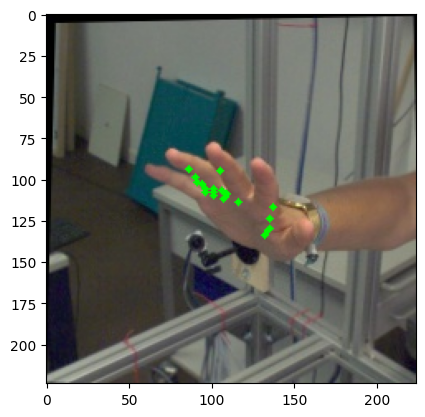

In [325]:
model.eval()
val_id = random.randint(0,len(img_list))
print(val_id)
# image_name = f"{image_dir}/{val[val_id]['file_name']}"
image_name = img_list[val_id]
image = Image.open(image_name).convert('RGB')
image = np.asarray(image)
pred = model(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

for i in range(0, len(pred), 2):
# for i in range(10, 17, 2):
    x = int(pred[i]*224 )
    y = int(pred[i+1] * 224)
    image = cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
plt.imshow(image)
